# xG

In [1]:
! pip install gandula

  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.0/74.0 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 83.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.8/85.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 87.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.3/10.3 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 90.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.9/202.9 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 91.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 kB 4.9 MB/s eta

Esse notebook mostra como implementar um modelo de Expectativa de Gols do zero até ter ele completo.

## Imports

In [1]:
import gandula

In [2]:
gandula

<module 'gandula' from '/home/joao/Projetos/robozao/.venv/robozao/lib/python3.12/site-packages/gandula/__init__.py'>

In [43]:
import os
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

## Coleta de dados

A PFF fornece dois tipos de dado, que podem vir de jeitos diferentes:

- dados de evento: json ou via API
- dados de tracking: json

Para loadar frames, é só usar os a célula abaixo como modelo. O problema é que isso demora: dados de tracking são pesados.

In [91]:
data_dir = os.getcwd() + '/_data'

In [92]:
# frames = gandula.get_frames(
#     data_dir=f'{data_dir}/tracking/world-cup/2022', match_id=3813
# )

Exception: Error getting frames for match_id=3813

Para loadar os dados de evento, a célula abaixo faz a requisição na API para conseguir os dados de uma partida. Com o gandula, se você possuir uma chave de API da PFF, é só fazer isso.

In [ ]:
# gandula.get_match_events(3813)

Caso você não tenha acesso a uma chave de API da PFF, mas tenha acesso aos dados em json, você pode utilizar a seguinte célula.

In [ ]:
# events = gandula.get_match(3813, events_path=f'{data_dir}/event/world-cup/2022').gameEvents

Com dados de tracking e de evento, podemos unir o útil ao agradável, e criar os enhanced frames: dados de evento melhorados

In [ ]:
# enhanced_events = gandula.get_enhanced_frames(
#     match_id=3813, data_dir=f'{data_dir}/tracking/world-cup/2022', events_path=f'{data_dir}/event/world-cup/2022'
# )

Finalmente, se você estiver interessado apenas em dados de chutes, como é o nosso caso, você pode extraí-los da seguinte maneira

In [ ]:
# game_frames = gandula.get_enhanced_frames(
#     data_dir=f'{data_dir}/tracking/world-cup/2022',
#     match_id=3813,
#     events_path=f'{data_dir}/event/world-cup/2022',
# )

# shot_frames = gandula.utils.frames.get_shot_frames(game_frames)

O dado de todos os chutes de todas as partidas do dataset foi pre-processado para facilitar nossas vida. Em outros notebooks da biblioteca, você pode checar como ele foi gerado. Podemos extraí-lo da seguinte forma:

In [5]:
shot_frames = gandula.loader.read_pickle(
    'data/enhaced_frames_shots.pkl'
)

## Exploração dos dados

Vamos primeiro ver como os chutes aparecem.

In [6]:
type(shot_frames)

list

Se é uma lista vamos ver com os chutes aparecem.

In [7]:
shot_frames[:5]

[{'frame': Frame 9282 - 130.66371,
  'event': PFF_PossessionEventType.SHOT=6511176},
 {'frame': Frame 20398 - 501.567947,
  'event': PFF_PossessionEventType.SHOT=6512525},
 {'frame': Frame 22485 - 571.20425,
  'event': PFF_PossessionEventType.SHOT=6511957},
 {'frame': Frame 36063 - 1024.257303,
  'event': PFF_PossessionEventType.SHOT=6511049},
 {'frame': Frame 41923 - 1219.786165,
  'event': PFF_PossessionEventType.SHOT=6511298}]

Bem, não extraímos muita informação disso. Mas conseguimos vizualizar que temos em cada chute, dois valores: o frame do chute, e o evento do chute. Vamos entender um pouco melhor sobre cada um, usando o primeiro chute como exemplo. Por sorte, o gandula nos ajuda também na visualização.

<Axes: >

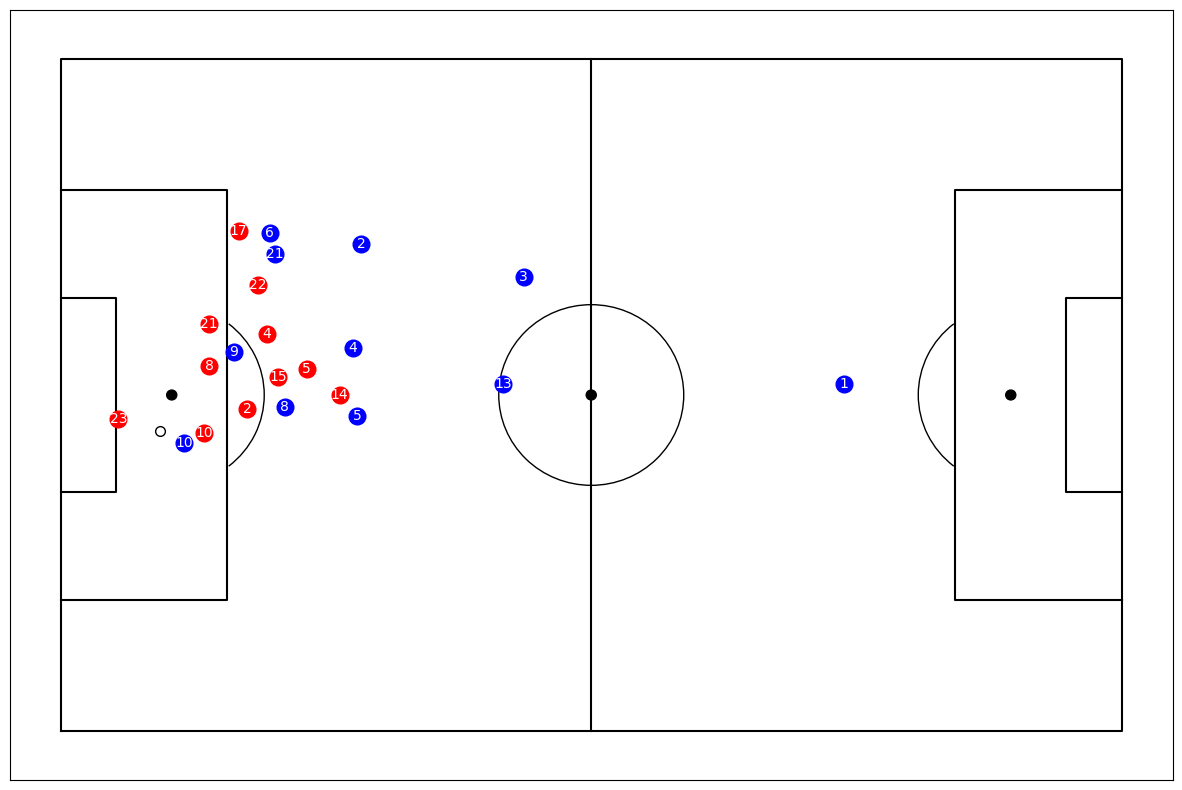

In [8]:
gandula.view(shot_frames[0]['frame'])

In [62]:
shot_frames[0]['frame'].possession

Possession(duration_seconds=None, end_time_seconds=None, game_clock='02:10', game_event_id=6629878, game_id=10502, inserted_at=datetime.datetime(2022, 12, 3, 17, 25, 49), possession_event_type=<PossessionEventType.SHOT: 'SH'>, start_time_seconds=309.71, updated_at=datetime.datetime(2022, 12, 3, 18, 49, 25), start_frame=9282, end_frame=None)

In [54]:
type(shot_frames[0]['frame'])

gandula.providers.pff.schema.tracking.PFF_Frame

Parece ser um chute do número 10 do time de azul! Como podemos vizualizar isso no dado em si?

In [47]:
shot_frames[0]['event'].shootingEvent.model_dump()

{'blockerPlayer': None,
 'clearerPlayer': None,
 'createsSpace': None,
 'deflectionPointX': None,
 'deflectionPointY': None,
 'deflectorBodyType': None,
 'deflectorPlayer': None,
 'goalLineEndPointX': None,
 'goalLineEndPointY': None,
 'goalLineStartPointX': None,
 'goalLineStartPointY': None,
 'goalkeeperPointX': None,
 'goalkeeperPointY': None,
 'id': None,
 'keeperTouchPointX': None,
 'keeperTouchPointY': None,
 'keeperTouchType': None,
 'period': None,
 'possessionEvent': None,
 'pressurePlayer': None,
 'pressureType': None,
 'saveHeightType': <ShotHeightType.BOTTOM_THIRD: 'BOTTOMTHIRD'>,
 'savePointX': None,
 'savePointY': None,
 'saveReboundType': <SaveReboundType.RIGHT_OUT_OF_BOX: 'RO'>,
 'saverPlayer': {'id': '11241',
  'dob': None,
  'firstName': None,
  'gender': None,
  'height': None,
  'lastName': None,
  'nickname': 'Andries Noppert',
  'preferredFoot': None,
  'weight': None,
  'positionGroupType': None,
  'nationality': None,
  'secondNationality': None,
  'countryOfBir

In [74]:
res = shot_frames[3]['event'].shootingEvent.model_dump(
    exclude_none=True, exclude_unset=True
)

list(res.keys())

['shooterPlayer',
 'shotBodyType',
 'shotInitialHeightType',
 'shotNatureType',
 'shotOutcomeType',
 'shotPointX',
 'shotPointY']

In [89]:
print(shot_frames[80]['event'].shootingEvent.shooterPlayer.id)

8342


Podemos observar que a integração dos dados de rastreio e de evento feita pelo gandula nos entrega a bola nas mãos: todo o poder do detalhado dado da PFF na ponta do seu teclado.

## Tratamento dos dados

No modelo de xG que vamos desenvolver aqui, vamos precisar extrair o ângulo para o gol e a distância. Além disso, é necessário saber se o chute resultou em gol ou não. Vamos gerar esses dados para cada chute.

Para facilitar os cálculos, vou transformar os dados gerados pelo gandula em um dataframe.

In [11]:
data = [
    {
        'event_id': frame['frame'].event_id,
        'frame_id': frame['frame'].frame_id,
        'x': frame['event'].shootingEvent.shotPointX,
        'y': frame['event'].shootingEvent.shotPointY,
        'outcome': frame['event'].shootingEvent.shotOutcomeType,
        'body_part': frame['event'].shootingEvent.shotBodyType,
        'set_piece': frame[
            'frame'
        ].event.setpiece_type,
    }
    for frame in shot_frames
]

df = pd.DataFrame(data)
df = (
    df.drop_duplicates()
)  # TODO: fix enhanced shot frames: there shouldn't be duplicates
df.head()

,event_id,frame_id,x,y,outcome,body_part,set_piece
0,6629878,9282,-40.281,-4.868,ShotOutcomeType.ON_TARGET,BodyType.LEFT_FOOT,None
1,6631191,20398,20.974,-12.711,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None
2,6630642,22485,16.634,-13.580,ShotOutcomeType.GOAL,BodyType.RIGHT_FOOT,None
3,6629751,36063,15.746,14.719,ShotOutcomeType.OFF_TARGET,BodyType.LEFT_FOOT,None
4,6630005,41923,-4.834,-21.644,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None


In [12]:
df

(1518, 7)

Para extrair a distância, vamos utilizar a distância euclideana. Para fazer o cálculo, precisamos considerar que os chutes podem sair dos dois lados do campo. A PFF tem como padrão nos seus dados direcionar o campo de acordo com o que a câmera mostra na transmissão. Além disso, as coordenadas são centralizadas no meio de campo. Vamos assumir que os atacantes estão sempre no campo adversário para chutar. Com isso, conseguimos extrair corretamente o dado.

Iremos setar como padrão que o time que está chutando ataca sempre da direita para a esquerda, para facilitar o cálculo. Isso quer dizer que o centro do gol está sempre na coordenada y = 0 e x = 52.5.

In [13]:
# espelhando chutes com x negativo
df.loc[df['x'] < 0, 'y'] = df.loc[df['x'] < 0, 'y'] * -1
df.loc[df['x'] < 0, 'x'] = df.loc[df['x'] < 0, 'x'] * -1

# calculando a distância do chute para o gol
df['dist'] = np.sqrt((df['x'] - 52.5) ** 2 + (df['y'] - 0) ** 2)

df.head()

,event_id,frame_id,x,y,outcome,body_part,set_piece,dist
0,6629878,9282,40.281,4.868,ShotOutcomeType.ON_TARGET,BodyType.LEFT_FOOT,None,13.152999
1,6631191,20398,20.974,-12.711,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None,33.992031
2,6630642,22485,16.634,-13.580,ShotOutcomeType.GOAL,BodyType.RIGHT_FOOT,None,38.350833
3,6629751,36063,15.746,14.719,ShotOutcomeType.OFF_TARGET,BodyType.LEFT_FOOT,None,39.591735
4,6630005,41923,4.834,21.644,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None,52.349883


Para extrair o ângulo, precisamos pensar na geometria do chute.
Para calcular o ângulo do gol, θ, tomamos a coordenada (x,y) do chute
- x é a distância ao longo da borda do campo desde a linha do gol;
- y é a distância do meio do campo.
- (0,0) é o ponto na linha de fundo no meio do gol.
O ângulo entre dois vetores que apontam para as traves é:
$$
\tan(\theta) = \frac{7.32x}{x^2 + y^2 - \left(\frac{7.32}{2}\right)^2}
$$
- onde 7.32 é o tamanho do gol.


In [14]:
df['ang'] = np.arctan((7.32 * df['x']) / (df['x'] ** 2 + (7.32 - df['y']) ** 2))

df.head()

,event_id,frame_id,x,y,outcome,body_part,set_piece,dist,ang
0,6629878,9282,40.281,4.868,ShotOutcomeType.ON_TARGET,BodyType.LEFT_FOOT,None,13.152999,0.179112
1,6631191,20398,20.974,-12.711,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None,33.992031,0.180536
2,6630642,22485,16.634,-13.580,ShotOutcomeType.GOAL,BodyType.RIGHT_FOOT,None,38.350833,0.169025
3,6629751,36063,15.746,14.719,ShotOutcomeType.OFF_TARGET,BodyType.LEFT_FOOT,None,39.591735,0.363845
4,6630005,41923,4.834,21.644,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None,52.349883,0.153607


Por fim, vamos extrai quando temos um gol e quando não.

In [15]:
df['gol'] = df['outcome'] == gandula.providers.pff.schema.event.ShotOutcomeType.GOAL
df.head()

,event_id,frame_id,x,y,outcome,body_part,set_piece,dist,ang,gol
0,6629878,9282,40.281,4.868,ShotOutcomeType.ON_TARGET,BodyType.LEFT_FOOT,None,13.152999,0.179112,False
1,6631191,20398,20.974,-12.711,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None,33.992031,0.180536,False
2,6630642,22485,16.634,-13.580,ShotOutcomeType.GOAL,BodyType.RIGHT_FOOT,None,38.350833,0.169025,True
3,6629751,36063,15.746,14.719,ShotOutcomeType.OFF_TARGET,BodyType.LEFT_FOOT,None,39.591735,0.363845,False
4,6630005,41923,4.834,21.644,ShotOutcomeType.OFF_TARGET,BodyType.RIGHT_FOOT,None,52.349883,0.153607,False


Além do ângulo, é importante temos mais insighs sobre comos chutes são feitos e sua distribuição

In [16]:
df['body_part'].value_counts()

body_part
BodyType.RIGHT_FOOT         768
BodyType.LEFT_FOOT          466
BodyType.HEAD               261
BodyType.RIGHT_BACK_HEEL      4
BodyType.LEFT_KNEE            4
BodyType.RIGHT_SHIN           4
BodyType.LEFT_SHOULDER        3
BodyType.LEFT_SHIN            2
BodyType.RIGHT_KNEE           2
BodyType.RIGHT_THIGH          2
BodyType.RIGHT_HAND           1
BodyType.TWO_HAND_PALM        1
Name: count, dtype: int64

In [17]:
df['set_piece'].value_counts()

Series([], Name: count, dtype: int64)

In [18]:
df['gol'].sum() / df['gol'].count()

np.float64(0.1251646903820817)

Antes de continuar, vamos limpar um pouco o dado. A natureza de cabeceios é um pouco diferente de chutes. Vamos buscar analisar apenas chutes.

In [19]:
shots = df[
    df['body_part'].isin(
        [
            gandula.providers.pff.schema.event.BodyType.RIGHT_FOOT,
            gandula.providers.pff.schema.event.BodyType.LEFT_FOOT,
            gandula.providers.pff.schema.event.BodyType.RIGHT_KNEE,
            gandula.providers.pff.schema.event.BodyType.LEFT_KNEE,
            gandula.providers.pff.schema.event.BodyType.RIGHT_BACK_HEEL,
            gandula.providers.pff.schema.event.BodyType.LEFT_BACK_HEEL,
            gandula.providers.pff.schema.event.BodyType.RIGHT_THIGH,
            gandula.providers.pff.schema.event.BodyType.LEFT_THIGH,
        ]
    )
]

Vamos agora entender um pouco mais sobre como esssas mediads influenciam em obter um gol ou não.

## Análise: Distância do Gol

A primeira intuição que temos é que quanto mais distante do gol, mais difícil de se marcar um gol. Vamos verificar se esse é o caso.

Vamos usar o gandula para plotar a distribuição dos chutes que nos selecionamos e também plotar quais desses chutes resultam em gols.

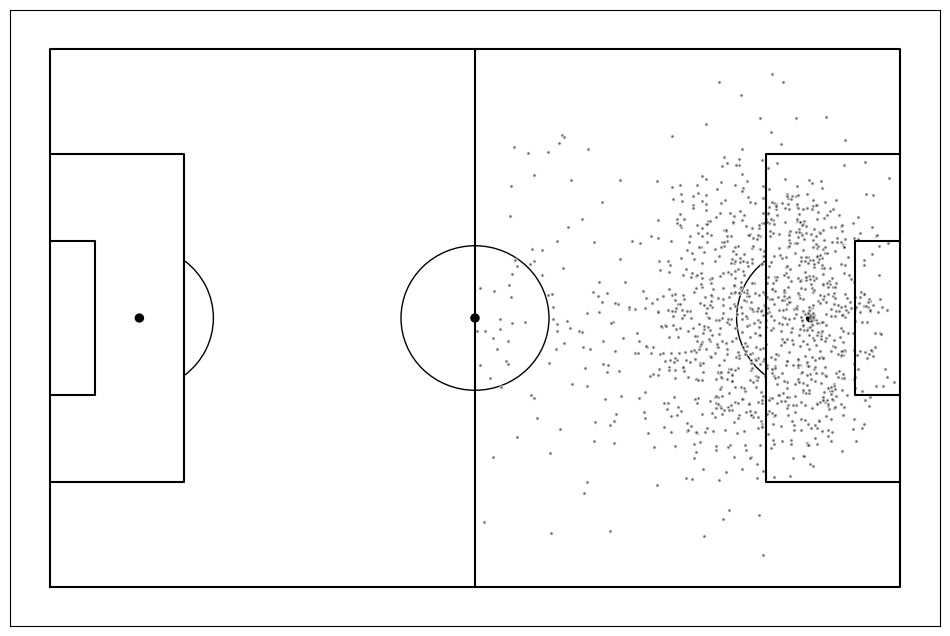

In [20]:
pitch = gandula.viz.pitch.Pitch()
gandula.plot_shot_map(pitch, shots)

In [21]:
shots[shots['gol']].shape

(160, 10)

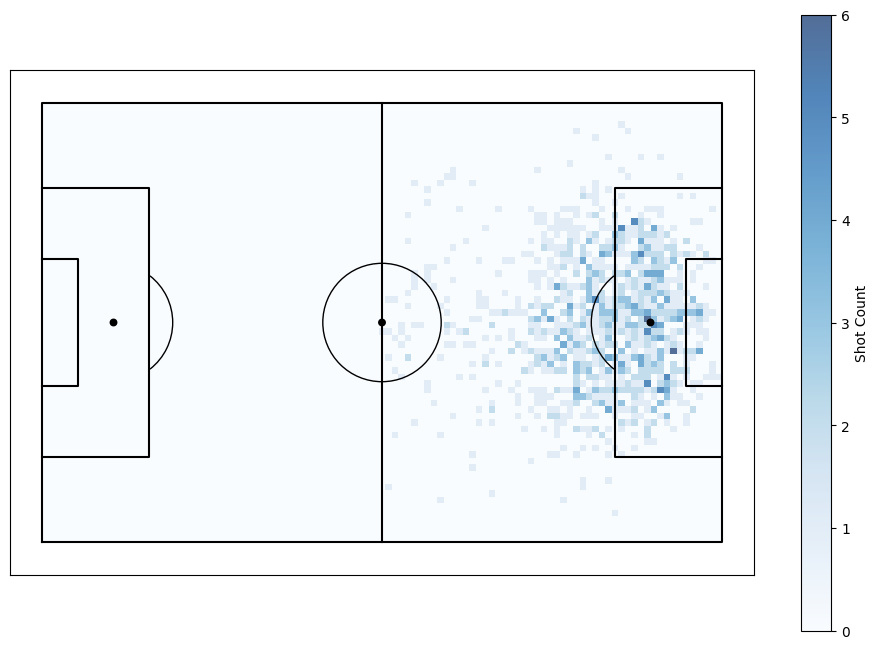

In [22]:
pitch = gandula.viz.pitch.Pitch()
gandula.plot_shot_map(pitch, shots, circle=False, distribution=True)

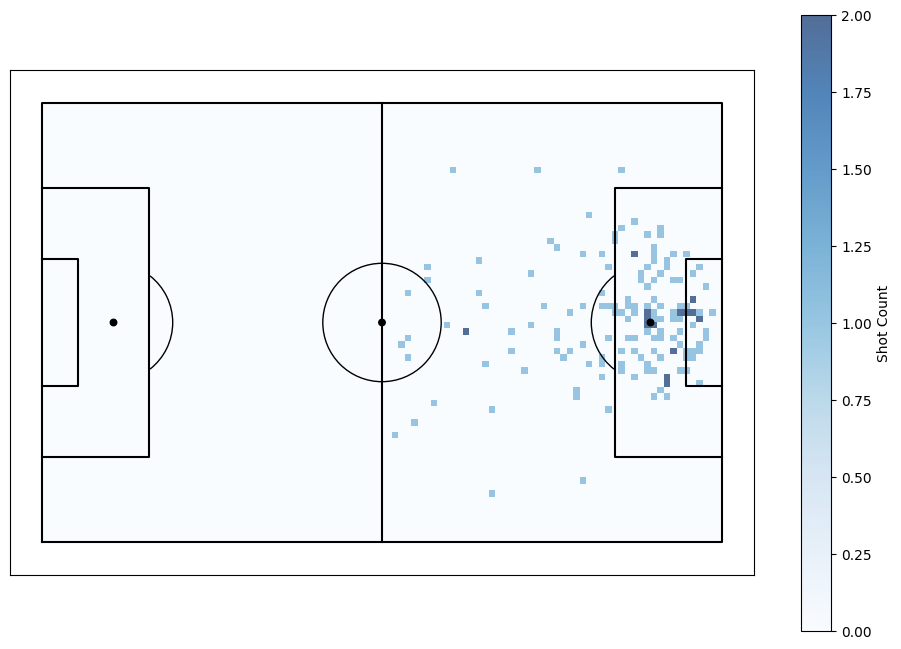

In [23]:
pitch = gandula.viz.pitch.Pitch()

gandula.plot_shot_map(pitch, shots[shots['gol']], circle=False, distribution=True)

Bem, se temos o número de chutes em cada quadrante do campo, e o número de gols em cada um deles, podemos dividí-los, e teremos a probabilidade de termos um gol em cada quadrante.

/tmp/ipykernel_179308/1675855658.py:23: RuntimeWarning: invalid value encountered in divide
  prob_goal = statistic_goals / statistic_shots


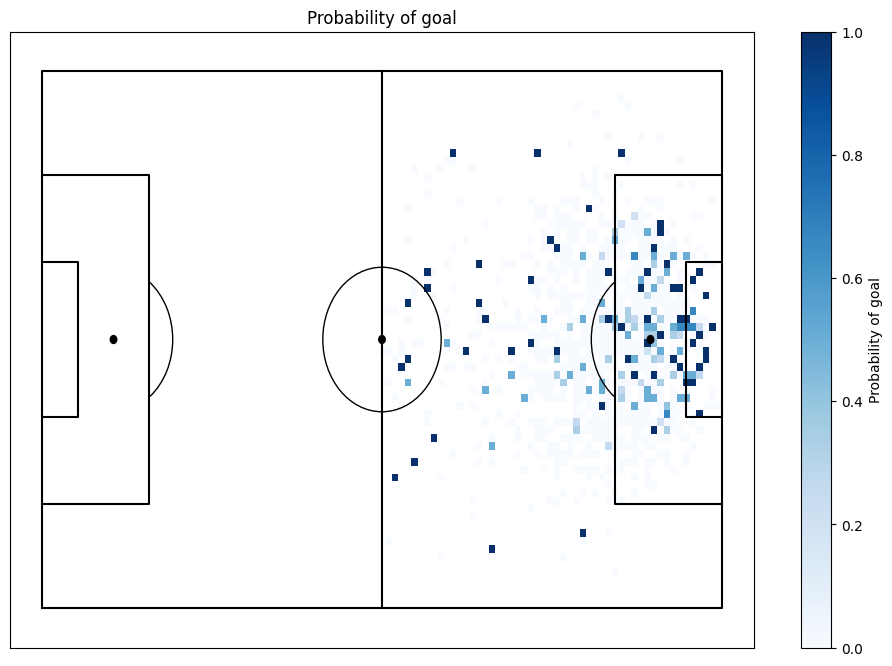

In [24]:
shots_for_plot = shots.copy()

# puts data on [0,105],[0,68] instead of [-52.5,52.5],[-34,34]
shots_for_plot.loc[:, 'x'] = shots_for_plot.loc[:, 'x'] + pitch.width / 2
shots_for_plot.loc[:, 'y'] = shots_for_plot.loc[:, 'y'] + pitch.height / 2

goals_for_plot = shots_for_plot[shots_for_plot['gol']]

pitch = gandula.viz.pitch.Pitch()
ax = pitch.draw_pitch()

x_bins = np.arange(0, pitch.width + 1)
y_bins = np.arange(0, pitch.height + 1)

statistic_shots, _, _ = np.histogram2d(
    shots_for_plot['x'], shots_for_plot['y'], bins=[x_bins, y_bins]
)

statistic_goals, _, _ = np.histogram2d(
    goals_for_plot['x'], goals_for_plot['y'], bins=[x_bins, y_bins]
)

prob_goal = statistic_goals / statistic_shots

plt.imshow(
    prob_goal.T,
    origin='lower',
    extent=(0, pitch.width, 0, pitch.height),
    aspect='auto',
    cmap='Blues',
)
plt.colorbar(label='Probability of goal')
plt.title('Probability of goal')

plt.show()

Então, isso é xG? Não! Não queremos overfitar o modelo: queremos que ele aprenda, dado algumas características, qual a qualidade que aquele chute apresenta.

## Análise: Distância do Gol

Vamos usar o conceito de regressão logística para calcular a probabilidade de obtermos um gol dado a distância do chute.

Primeiro, vamos plotar se um gol foi marcado dado um a distância do chute.

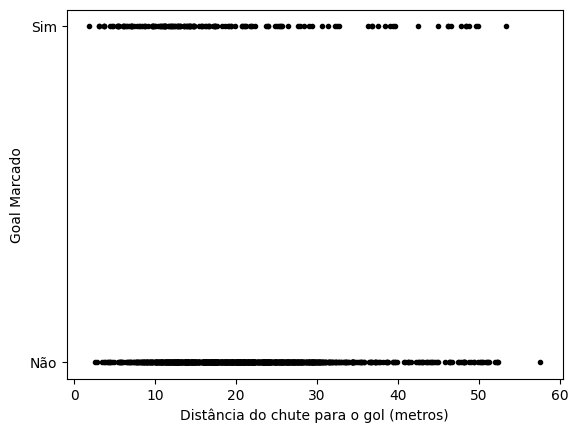

In [25]:
fig, ax = plt.subplots()
ax.plot(
    shots['dist'],
    shots['gol'],
    linestyle='none',
    marker='.',
    markersize=6,
    color='black',
)
ax.set_ylabel('Goal Marcado')
ax.set_xlabel('Distância do chute para o gol (metros)')
plt.ylim((-0.05, 1.05))
ax.set_yticks([0, 1])
ax.set_yticklabels(['Não', 'Sim'])
plt.show()

## Investigando a relação entre a probabilidade de marcar gols e a distância
Queremos descobrir se a distância influencia a probabilidade de marcar um gol. Primeiro, vamos plotar a probablidade de termos um gol dado o ângulo usando a mesma estratégia de antes: agrupando os dados fazendo a divisão.

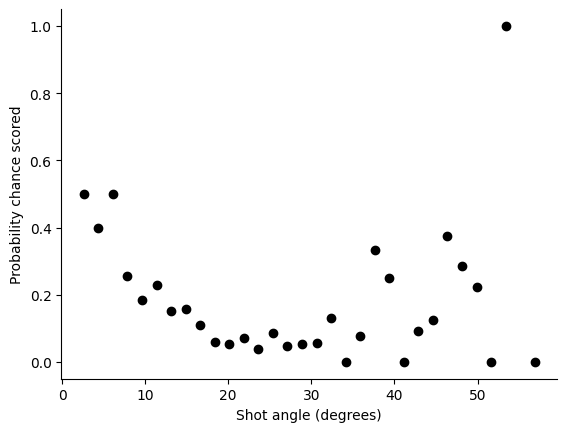

In [26]:
# number of shots from dist
shotcount_dist = np.histogram(shots['dist'], bins=40, range=[0, 70])

# number of goals from dist
goalcount_dist = np.histogram(
    shots[shots['gol']]['dist'], bins=40, range=[0, 70]
)
np.seterr(divide='ignore', invalid='ignore')

# probability of scoring goal
prob_goal = np.divide(goalcount_dist[0], shotcount_dist[0])
dist = shotcount_dist[1]
middist = (dist[:-1] + dist[1:]) / 2

# make plot
fig, ax = plt.subplots()
ax.plot(middist, prob_goal, linestyle='none', marker='.', markersize=12, color='black')
ax.set_ylabel('Probability chance scored')
ax.set_xlabel('Shot angle (degrees)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Ajuste de regressão logística com coeficientes aleatórios
Nosso conjunto de dados foi ajustado a uma curva de regressão logística com parâmetros definidos - 10 para o intercepto e -0.25 para a distância. No entanto, é muito provável que esses não sejam os melhores estimadores dos parâmetros verdadeiros.

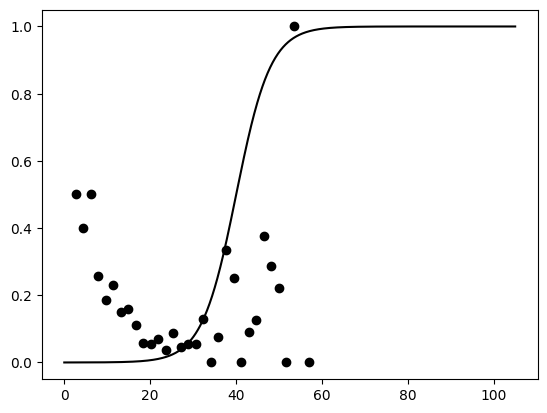

In [27]:
fig, ax = plt.subplots()
b = [10, -0.25]
x = np.arange(105, step=0.1)
y = 1 / (1 + np.exp(b[0] + b[1] * x ))
# plot line
ax.plot(middist, prob_goal, linestyle='none', marker='.', markersize=12, color='black')
# plot logistic function
ax.plot(x, y, linestyle='solid', color='black')
plt.show()

### Calculando a verossimilhança logarítmica
Os melhores parâmetros são aqueles que maximizam a verossimilhança logarítmica.

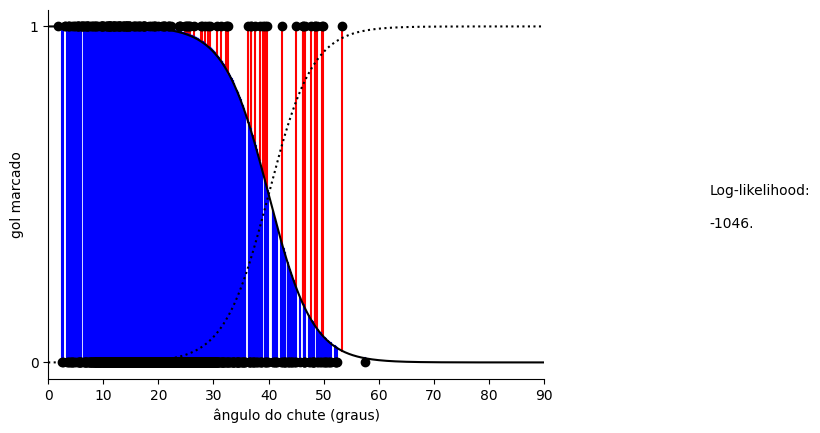

In [28]:
# calculate xG
xG = 1 / (1 + np.exp(b[0] + b[1] * shots['dist']))
shots = shots.assign(xG_dist=xG)
fig, ax = plt.subplots()

# plot data
ax.plot(
    shots['dist'],
    shots['gol'],
    linestyle='none',
    marker='.',
    markersize=12,
    color='black',
    zorder=3,
)

# plot curves
ax.plot(x, y, linestyle=':', color='black', zorder=2)
ax.plot(x, 1 - y, linestyle='solid', color='black', zorder=2)

# calculate loglikelihood
loglikelihood = 0

for _, shot in shots.iterrows():
    dist = shot['dist']
    if shot['gol'] == 1:
        loglikelihood = loglikelihood + np.log(shot['xG_dist'])
        ax.plot([dist, dist], [shot['gol'], 1 - shot['xG_dist']], color='red', zorder=1)
    else:
        loglikelihood = loglikelihood + np.log(1 - shot['xG_dist'])
        ax.plot([dist, dist], [shot['gol'], 1 - shot['xG_dist']], color='blue', zorder=1)

ax.set_ylabel('gol marcado')
ax.set_xlabel('ângulo do chute (graus)')
plt.ylim((-0.05, 1.05))
plt.xlim((0, 90))
plt.text(120, 0.5, 'Log-likelihood:')
plt.text(120, 0.4, str(loglikelihood)[:6])
ax.set_yticks([0, 1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Fitando a regressão logística e encontrando os melhores valores
Os melhores parâmetros são aqueles que maximizam a verossimilhança logarítmica.

Intercept: -1.139612371423033
Coeficiente angular: -0.039689680913662824


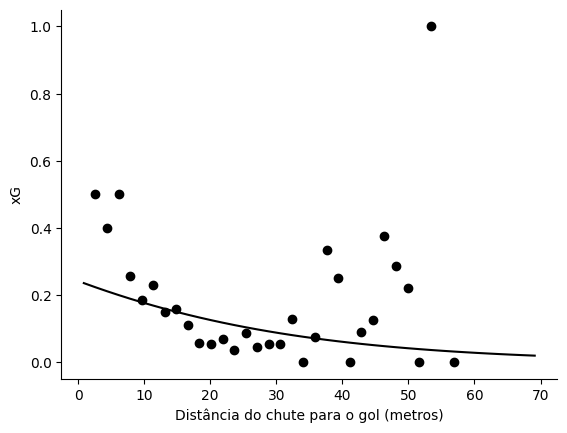

In [29]:
# Supondo que 'df' seja o dataframe com as colunas 'gol' e 'ang'
X = shots[['dist']].values  # A variável independente
y = shots['gol'].values  # A variável dependente (binária)

# Criando o modelo de regressão logística
model = LogisticRegression()
model.fit(X, y)

# Pegando os parâmetros
b0 = model.intercept_[0]
b1 = model.coef_[0][0]

print(f'Intercept: {b0}')
print(f'Coeficiente angular: {b1}')

# Calculando a probabilidade xG
xGprob = 1 / (1 + np.exp(-1 * (b0 + b1 * middist)))

# Plotando os resultados
fig, ax = plt.subplots()

# Plotando os dados
ax.plot(middist, prob_goal, linestyle='none', marker='.', markersize=12, color='black')

# Plotando a linha de regressão
ax.plot(middist, xGprob, linestyle='solid', color='black')

# Configurando as legendas e eixos
ax.set_ylabel('xG')
ax.set_xlabel('Distância do chute para o gol (metros)')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

In [30]:
# setar o xG no dataframe
shots = shots.assign(xG_dist=model.predict_proba(X)[:, 1])
# shots = shots.assign(xG_angle=1 / (1 + np.exp(-1*(b0 + b1 * X))))

## Avaliação do modelo: ROC AUC

Toda vez que criamos modelos, devemos avaliá-los para testar usa eficácia.

A Área Sob A Curva Característica de Operação do Receptor (ROC AUC) é um gráfico que relaciona taxa de verdadeiros positivos (TPR) vs. taxa de falsos positivos (FPR) em diferentes thresholds. Especificamente, sobre a AUC (Área Sob a Curva):
- AUC = 0.5: Desempenho aleatório.
- AUC = 1.0: Modelo perfeito.
Ou seja, quanto maior a AUC, melhor a discriminação do modelo. A vantagem do ROC AUC é que ele independente do threshold e vira uma comparação eficaz entre modelos.

Vamos obter o valor de auc para xG dist

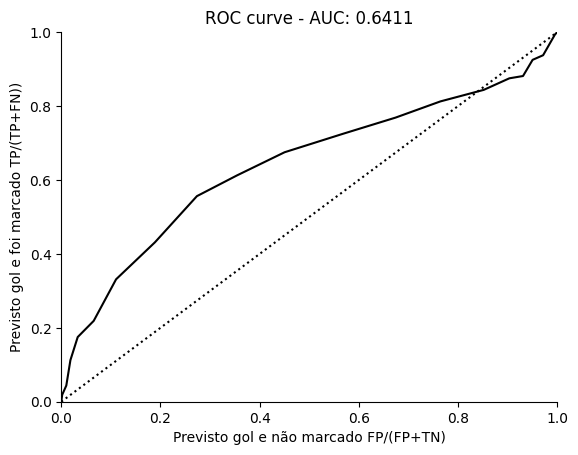

In [31]:
numobs = 100
TP = np.zeros(numobs)
FP = np.zeros(numobs)
TN = np.zeros(numobs)
FN = np.zeros(numobs)

for i, threshold in enumerate(np.arange(0, 1, 1 / numobs)):
    for _, shot in shots.iterrows():
        if shot['gol'] == 1:
            if shot['xG_dist'] > threshold:
                TP[i] = TP[i] + 1
            else:
                FN[i] = FN[i] + 1
        if shot['gol'] == 0:
            if shot['xG_dist'] > threshold:
                FP[i] = FP[i] + 1
            else:
                TN[i] = TN[i] + 1

auc = roc_auc_score(shots['gol'], shots['xG_dist'])

fig, ax = plt.subplots()
ax.plot(FP / (FP + TN), TP / (TP + FN), color='black')
ax.plot([0, 1], [0, 1], linestyle='dotted', color='black')
ax.set_ylabel('Previsto gol e foi marcado TP/(TP+FN))')
ax.set_xlabel("Previsto gol e não marcado FP/(FP+TN)")
plt.ylim((0.00, 1.00))
plt.xlim((0.00, 1.00))
plt.title(f'ROC curve - AUC: {auc:.4f}')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

## Submissão

Para submeter um arquivo para a nossa competição, você deverá juntar o possession id do chute e o frame id. Fazendo esse mapping, envie a previsão de todos os chutes da copa do mundo através do seu modelo.

In [32]:
df["xG"] = (1/(1 + np.exp(-1*(b0 + b1 * df['dist']))))

In [33]:
submission = df[['event_id', 'frame_id', 'xG']]
submission['shot_id'] = (
    submission['event_id'].astype(str) + '_' + submission['frame_id'].astype(str)
)
submission = submission.drop(columns=['event_id', 'frame_id'])
submission = submission.rename(columns={'xG_dist': 'xG'})
submission = submission[['shot_id', 'xG']]


/tmp/ipykernel_179308/610565281.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  submission['shot_id'] = (


In [36]:
test = pd.read_csv('data/test.csv')
submission = pd.merge(
    submission,
    test[["shot_id"]],
    on="shot_id"
)

In [37]:
submission.to_csv('submission.csv', index=False)